In [1]:
import json
from tqdm import tqdm
from utils import (
    calc_iou, any_match,
    gen_froc_plot, gen_tabular_data,
    gen_precision_recall_plot,
    convert_to_tensor
)
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score
)
from monai.data.box_utils import non_max_suppression
import torch

In [2]:
files = [
    'pixel-parsed-mixed_test-overjoyed-hen-305',
    'pixel-parsed-mixed_test-indecisive-eel-172',
    'pixel-parsed-mixed_test-crawling-sloth-537',
    'pixel-parsed-mixed_test-powerful-goat-766',
    'pixel-parsed-all'
]

In [3]:
all_fps_per_image = []
all_total_sensitivity = []
tabular_data = []
all_testy = []
all_lr_probs = []

composed_fp_probs = []
composed_tp_probs = []
composed_tp, composed_fp, composed_fn = 0, 0, 0
composed_testy = []
composed_lr_probs = []

for file_name in files:

    data_list_file_path = f'/data/output/validation/each_window/{file_name}.json' # all datasets
    # data_list_file_path = f'/data/output/validation/each_window/luna/{file_name}.json' # only luna16
    # data_list_file_path = f'/data/output/validation/each_window/hc/{file_name}.json' # only luna16
    # data_list_file_path = f'/data/output/validation/each_window/msd/{file_name}.json' # only luna16

    f = open(data_list_file_path)
    data = json.load(f)

    iou_thresh = 0.5 # same as Lucas
    num_images = 155
    num_targets = 313
    # num_images = 121
    # num_targets = 273
    # num_images = 21
    # num_targets = 27
    # num_images = 13
    # num_targets = 13

    fp_probs = []
    tp_probs = []
    tp, fp, fn = 0, 0, 0

    testy = []
    lr_probs = []

    for content in tqdm(data['test']):

        # convert pred_box to monai standard arrangement mode
        converted = convert_to_tensor(content['pred_box'])

        keep = non_max_suppression(
            converted, torch.tensor(content['score']), nms_thresh=0.1, max_proposals=100)

        # boxes_after_nms = content['pred_box'][keep]
        boxes_after_nms = [content['pred_box'][index] for index in keep]
        scores_after_nms = torch.tensor(content['score'])[keep]

        for pred_box, score in zip(boxes_after_nms, scores_after_nms):
            # if score > 0.5:
            iou = 0
            if any_match(content['true_box'][0], pred_box):
                iou = calc_iou(content['true_box'][0], pred_box)
            if iou >= iou_thresh:
                tp += 1
                tp_probs.append(score)
                composed_tp += 1
                composed_tp_probs.append(score)

                testy.append(1)
                lr_probs.append(score)
                composed_testy.append(1)
                composed_lr_probs.append(score)
            if iou < iou_thresh and iou > 0:
                fp += 1
                fp_probs.append(score)
                composed_fp += 1
                composed_fp_probs.append(score)

                testy.append(0)
                lr_probs.append(score)
                composed_testy.append(0)
                composed_lr_probs.append(score)
            if iou == 0:
                fn += 1
                composed_fn += 1

                testy.append(0)
                lr_probs.append(score)
                composed_testy.append(0)
                composed_lr_probs.append(score)

    fps_per_image, total_sensitivity, precision, recall, p1, p2, p3, p4, p5, p6 ,p7, cpm = gen_tabular_data(
        tp, fp, fn, fp_probs, tp_probs, num_images, num_targets
    )

    all_fps_per_image.append(fps_per_image)
    all_total_sensitivity.append(total_sensitivity)
    all_testy.append(testy)
    all_lr_probs.append(lr_probs)

    tabular_data.append({
        # "precision": precision,
        # "recall": recall,
        # "tp": tp,
        # "fn": fn,
        # "fp": fp,
        "1/8": p1,
        "2/8": p2,
        "4/8": p3,
        "1": p4,
        "2": p5,
        "4": p6,
        "8": p7,
        "CPM": cpm,
        # "AP": str(average_precision_score(testy, lr_probs))
    })

first_table = pd.DataFrame(tabular_data)

100%|██████████| 246/246 [00:17<00:00, 14.38it/s]


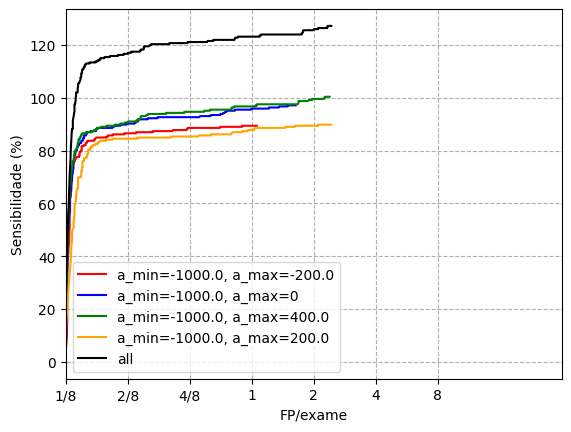

In [4]:
gen_froc_plot(all_fps_per_image, all_total_sensitivity)

In [5]:
first_table

,1/8,2/8,4/8,1,2,4,8,CPM
0,0.747967,0.796748,0.849593,0.865854,0.886179,0.894309,0.894309,0.847851
1,0.755081,0.829268,0.882114,0.902439,0.926829,0.971545,0.971545,0.891260
2,0.760163,0.853659,0.882114,0.906504,0.947154,0.995935,1.004065,0.907085
3,0.506436,0.706301,0.825203,0.845528,0.853659,0.894309,0.898374,0.789973
4,0.925813,1.080285,1.138211,1.166667,1.211382,1.258130,1.272358,1.150407


In [6]:
# gen_precision_recall_plot(precision_recall_curve, all_testy, all_lr_probs)